### Les Modules

In [1]:
# Importation des modules

import math 
import math_mod as mm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotting as pltg
import sampling_techniques as st
import seaborn as sns
import typing as tp
import utilitaire as ut

from pinard import nirs_set as n_set
from pinard import preprocessor as pp
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion

### Les préprocessing

In [2]:
# Préprocessing à effectuer pour les données spectrals

preprocessing = [   
                    ('id', pp.IdentityTransformer()),
                    ('savgol', pp.SavitzkyGolay()),
                    ('gaussian1', pp.Gaussian(order = 1, sigma = 2)),
                    ('gaussian2', pp.Gaussian(order = 2, sigma = 1)),
                    ('haar', pp.Wavelet('haar')),
                    ('savgol*savgol', Pipeline([('_sg1',pp.SavitzkyGolay()),('_sg2',pp.SavitzkyGolay())])),
                    ('gaussian1*savgol', Pipeline([('_g1',pp.Gaussian(order = 1, sigma = 2)),('_sg3',pp.SavitzkyGolay())])),
                    ('gaussian2*savgol', Pipeline([('_g2',pp.Gaussian(order = 1, sigma = 2)),('_sg4',pp.SavitzkyGolay())])),
                    ('haar*savgol', Pipeline([('_haar2',pp.Wavelet('haar')),('_sg5',pp.SavitzkyGolay())]))
                ]

### Les fonctions

In [3]:
# Fonction pour supprimer l'affichage des warnings sklearn

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
# Fonction transformant des ndarray en dataframes, et applique (au choix) un préprocessing, un retrait des outliers, et un MinMaxScaler

def to_dataframe(features: tp.Union[pd.DataFrame, np.ndarray, list],
                 labels: tp.Union[pd.DataFrame, np.ndarray, list],
                 pre_pro: bool=True,
                 scale: bool=True,
                 rm_outliers: bool=True,
                 random_state: tp.Union[int, None]=0) -> tp.Tuple[pd.DataFrame, pd.DataFrame]:
    
    # Transforme les features en dataframe, et le reshape, si besoin
     
    if not isinstance(features, pd.DataFrame):

        if len(features.shape) == 1:
            
            features = features.reshape(-1, 1)

        features = pd.DataFrame(data=features, columns=[i for i in range(0, features.shape[1], 1)])

    # Transforme les labels en dataframe, et le reshape, si besoin

    if not isinstance(labels, pd.DataFrame):

        if len(labels.shape) == 1:
            
            labels = labels.reshape(-1, 1)
                        
        labels = pd.DataFrame(data=labels, columns=["labels {}".format(i) for i in range(0, labels.shape[1], 1)])
        
    # Retire les outliers

    if rm_outliers:

        iso_f = IsolationForest(random_state=random_state)
        outliers = iso_f.fit_predict(features)

        features = features[outliers != -1]
        labels = labels[outliers != -1]

    # Effectue un préprocessing sur les features

    if pre_pro:

        p = FeatureUnion(preprocessing).fit(features)
        features = pd.DataFrame(data=p.transform(features), columns=[i for i in range(0, p.transform(features).shape[1], 1)])
    
    # Effectue un scale sur les labels

    if scale:

        sclr = MinMaxScaler().fit(labels)
        labels = pd.DataFrame(data=sclr.transform(labels), columns=sclr.get_feature_names_out())
    
    return (features, labels)

In [5]:
# Fonction permettant d'afficher les dimensions des jeux de données d'entraînement et de test 

def print_shape(a: pd.DataFrame,
                b: pd.DataFrame,
                c: pd.DataFrame,
                d: pd.DataFrame) -> None:

    print("x_train : {}\ny_train : {}\nx_test : {}\ny_test : {}\n".format(a.shape, b.shape, c.shape, d.shape))

In [6]:
# Fonction affichant un violinplot de la distribution des valeurs de la variable cible, entre le train_set et le test_set

def plot_distrib(y_train: pd.DataFrame, y_test: pd.DataFrame, largeur: int=10, hauteur: int=6) -> None:

    new_df = pd.concat([y_train.assign(Set="Train"), y_test.assign(Set="Test")], axis=0)

    new_df.columns = new_df.columns.str.replace('labels 0', 'Target')

    plt.figure(figsize=(largeur, hauteur))

    sns.violinplot(data=new_df, x="Target", y="Set")

    plt.title("Violinplot de la distribution des valeurs de la variable cible, dans le Train set et le Test set", pad=10)

    plt.show()

In [7]:
# Fonction affichant les scores de prédictions

def print_scores(y_test: tp.Union[tp.List[float], np.ndarray], pred: tp.Union[tp.List[float], np.ndarray]) -> None:

    for metric in ["mape", "mse", "mae", "rmse", "r2"]:

        print("{} = {}".format(metric.upper(), ut.metric_choice(y_test, pred, scoring=metric)))

In [8]:
# Fonction permettant de récupérer les scores des métriques

def get_df_metrics_values(dic_score: tp.Dict[tp.Tuple[str, int, str], float]) -> pd.DataFrame:

    # Récupération des clés et des valeurs du dictionnaire

    list_tup_keys = list(dic_score.keys())
    list_values = list(dic_score.values())

    # Transformation en dataframe

    df_score_metrics = pd.DataFrame({"Technique": [tup[0] for tup in list_tup_keys], 
                                     "Random_state": [tup[1] for tup in list_tup_keys], 
                                     "Metric": [tup[2] for tup in list_tup_keys],
                                     "Score": list_values})

    return df_score_metrics

In [9]:
# Fonction pour plotter les scores de métriques

def plot_metrics_values(df_score_metrics: pd.DataFrame, largeur: int=20, hauteur: int=20) -> None:

    # Itérateur de subplot

    i = 1

    # Affichage des scores(des métriques), en fonction des techniques
 
    plt.figure(figsize=(largeur, hauteur))

    for metric, color in zip(["mape", "mse", "mae", "rmse", "r2"], ["blue", "red", "green", "purple", "brown"]):

        df_tmp = df_score_metrics[df_score_metrics["Metric"] == metric]

        # Affichage des subplots
        
        plt.subplot(3, 2, i)
        
        plt.scatter(data=df_tmp.sort_values(by="Score", ascending=True),
                    x="Technique",
                    y="Score", edgecolors='black', c=color)

        plt.ylabel(metric.upper())
        plt.xlabel("Technique".upper())

        # Incrémentation de l'itérateur

        i+=1

    plt.show()

In [10]:
# Fonction retournant le score de performance

def score_perf(vec: tp.Tuple[float]) -> float:

    max_ = max(vec)

    return  (((max_/vec[0])*vec[0])**2 +
               ((max_/vec[1])*vec[1])**2 +
               ((max_/vec[2])*vec[2])**2 +
               ((max_/vec[3])*vec[3])**2 +
               ((max_/vec[4])*vec[4])**2)**0.5

In [11]:
# Fonction calculant un score de performance

def compute_score_perf(y_test: tp.Union[tp.List[float], np.ndarray], pred: tp.Union[tp.List[float], np.ndarray]) -> float:

    # Vecteur de coordonnées 

    vec_coord = []

    # Chaque métriques devient une coordonnée du vecteur

    for metric in ["mape", "mse", "mae", "rmse", "r2"]:

        if metric != "r2":

            vec_coord.append(ut.metric_choice(y_test, pred, scoring=metric))

        else:

            vec_coord.append(1 - ut.metric_choice(y_test, pred, scoring=metric))

    vec_coord = tuple(vec_coord)

    # Retouner le score de performance

    return score_perf(vec_coord)

In [12]:
# Fonction calculant le score de performance d'un modèle

def get_df_score_perf(df_score_metrics: pd.DataFrame, tab_tech: tp.List[str]) -> pd.DataFrame:

    # Tableau qui contiendra les points de coordonnées : (mape, mse, mae, rmse, r2)

    tab_points = []

    # Compteur de lignes

    line = 0

    # Pour chaque techniques de splitting

    for tech in tab_tech:

        # Récupérer les coordonnées de la technique

        vec_coord = []

        df_tmp = df_score_metrics[df_score_metrics["Technique"] == tech]

        for i in range(len(df_tmp)):

            if df_tmp.loc[line, ('Metric')] != "r2":

                vec_coord.append(df_tmp.loc[line, ('Score')])

            else: 
                
                vec_coord.append(1 - df_tmp.loc[line, ('Score')])

            line+=1

        # Transformer le tableau en tuple

        tab_points.append(tuple(vec_coord))

    # Calculer les scores de performance

    tab_norm = [score_perf(tup) for tup in tab_points]

    # Mise en forme des résultats

    df_tmp = pd.DataFrame({"Technique" : tab_tech,
                           "Score" : tab_norm})
    
    # Trier dans l'ordre croissant
    
    return df_tmp.sort_values(by=["Score"], ascending=True)

In [13]:
# Fonction calculant le score de performance en fonction de la technique

def plot_score_perf(df_score_perf: pd.DataFrame, largeur: int=12, hauteur: int=6) -> None:

    plt.figure(figsize=(largeur, hauteur))

    plt.scatter(data=df_score_perf,
                x="Technique",
                y="Score", edgecolors='black', c='blue')

    plt.ylabel("Score de performance")
    plt.xlabel("Technique")

    plt.show()

### Test de l'impact du mode de partage des données sur les prédictions du modèle XGBOOST

In [19]:
# Mise en place du tableau contenant les techniques de splitting à tester

tab_tech = ["kennard_stone", "k_mean", "cluster", "custom", "random", "SPlit", "spxy", "systematic"]

# Paramètrage des préprocessing à effectuer sur les données

pre_pro = True
scale = True
rm_outliers = False
random_state = 0

# Chargement des données

n = n_set.NIRS_Set('data')
features, labels = n.load('Xcal.txt', 'Ycal.txt', x_hdr=0, y_hdr=0, y_cols=0)
features, labels = to_dataframe(features=features,
                                labels=labels,
                                pre_pro=pre_pro,
                                scale=scale,
                                rm_outliers=rm_outliers,
                                random_state=random_state)

In [15]:
# Paramètres utilisés

n_iter = 500
test_size = 0.2
n_cluster = 8
pca = 0.999

# Lecture du fichier résultat

df_res = pd.read_csv("splitting_state_prtrt_scl_rdstt_0.csv")
df_res.rename(columns = {'tech':'Technique'}, inplace = True)

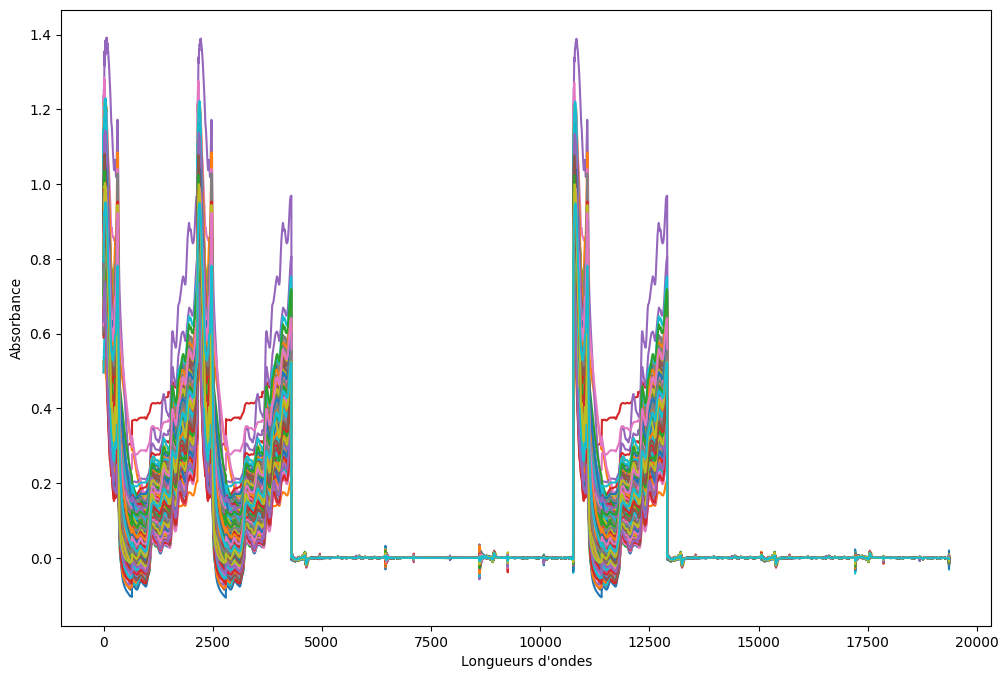

In [20]:
pltg.plot_NIRS_spectra(features, title="", y_lab="Absorbance", x_lab="Longueurs d'ondes")

Technique + valeur du MIN(dissimilarité) : (kennard_stone, 0) = 0.0072475080378353

x_train : (289, 19359)
y_train : (289, 1)
x_test : (72, 19359)
y_test : (72, 1)

MAPE = 0.24367974698543549
MSE = 0.015436266548931599
MAE = 0.09337121993303299
RMSE = 0.12424277514219284
R2 = -0.23008200526237488


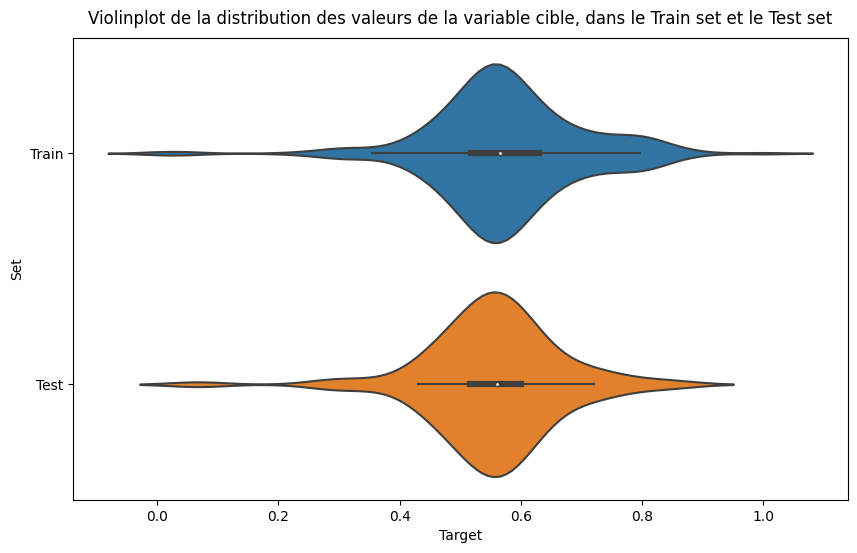

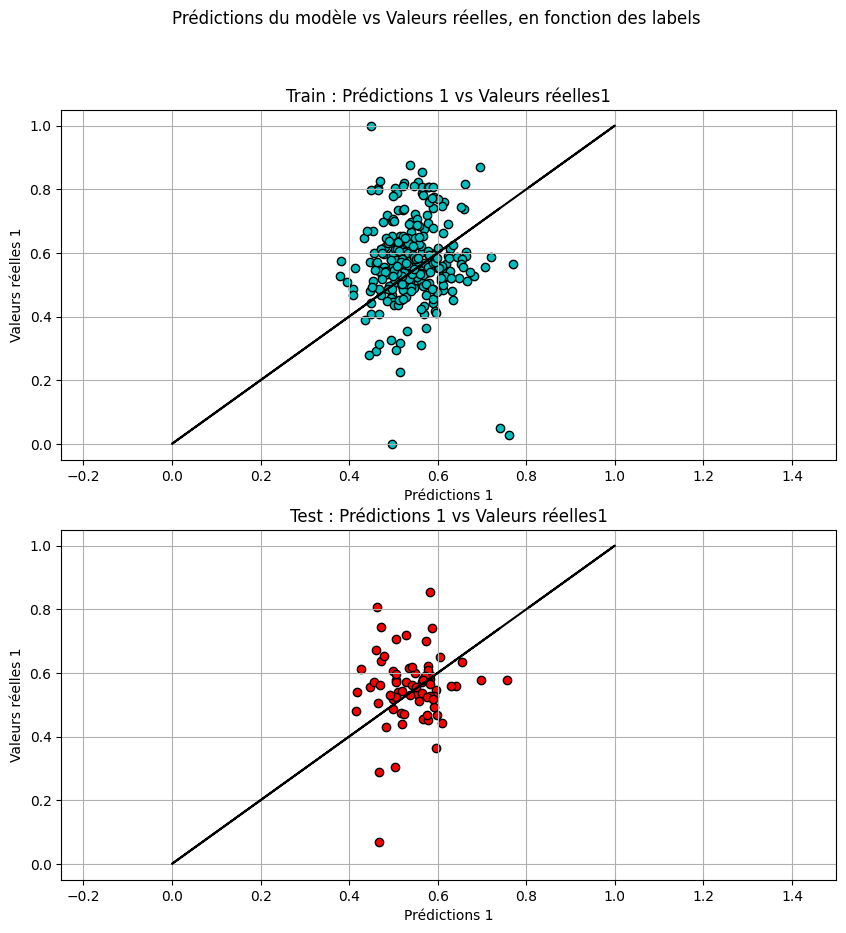

Technique + valeur du MIN(dissimilarité) : (k_mean, 16) = 0.0095417620614171

x_train : (289, 19359)
y_train : (289, 1)
x_test : (72, 19359)
y_test : (72, 1)

MAPE = 0.24367974698543549
MSE = 0.015436266548931599
MAE = 0.09337121993303299
RMSE = 0.12424277514219284
R2 = -0.23008200526237488


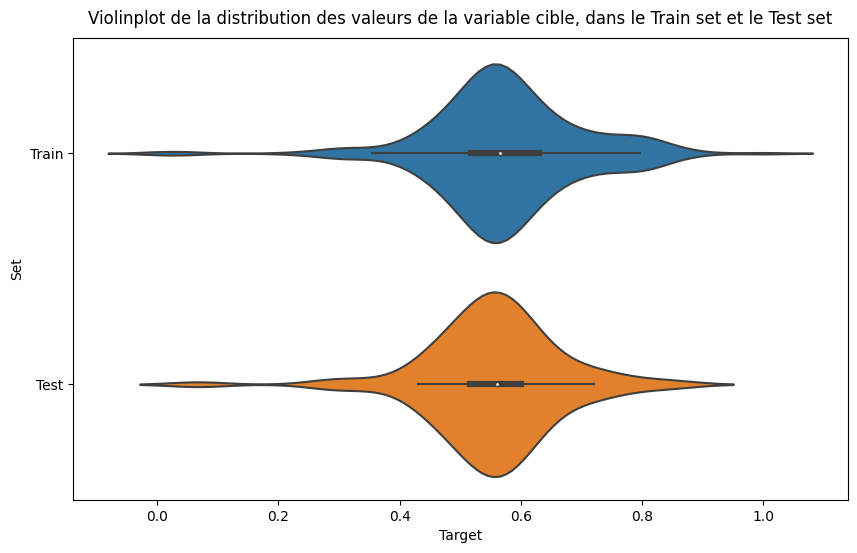

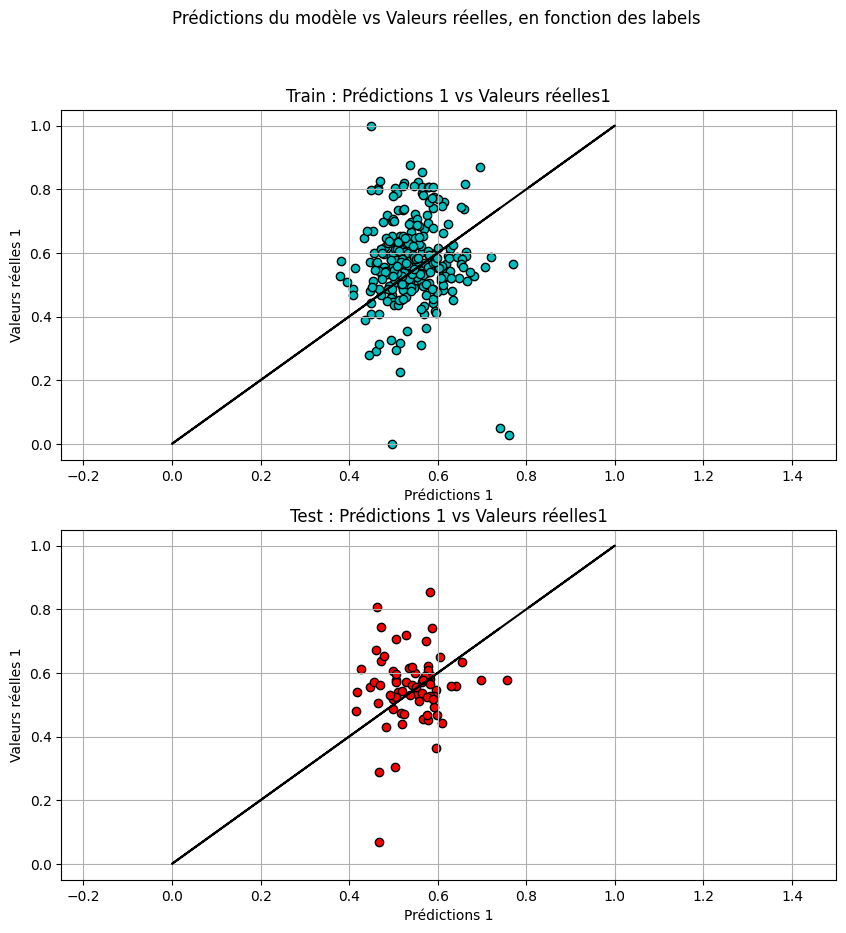

Technique + valeur du MIN(dissimilarité) : (cluster, 157) = 0.0014748643152415

x_train : (289, 19359)
y_train : (289, 1)
x_test : (72, 19359)
y_test : (72, 1)

MAPE = 0.24367974698543549
MSE = 0.015436266548931599
MAE = 0.09337121993303299
RMSE = 0.12424277514219284
R2 = -0.23008200526237488


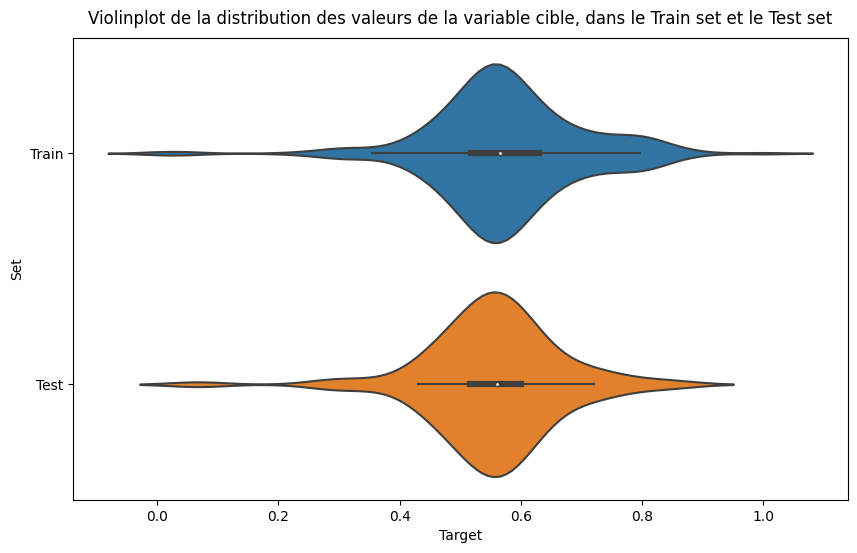

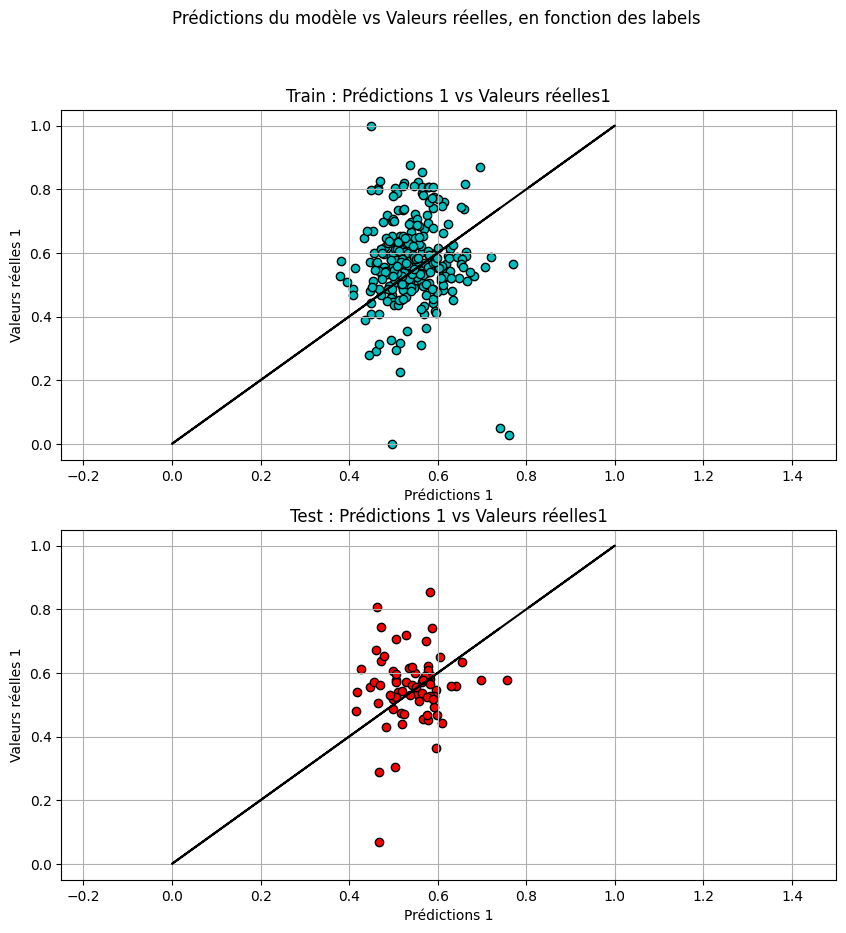

Technique + valeur du MIN(dissimilarité) : (custom, 313) = 0.0054986155591905

x_train : (289, 19359)
y_train : (289, 1)
x_test : (72, 19359)
y_test : (72, 1)

MAPE = 0.24367974698543549
MSE = 0.015436266548931599
MAE = 0.09337121993303299
RMSE = 0.12424277514219284
R2 = -0.23008200526237488


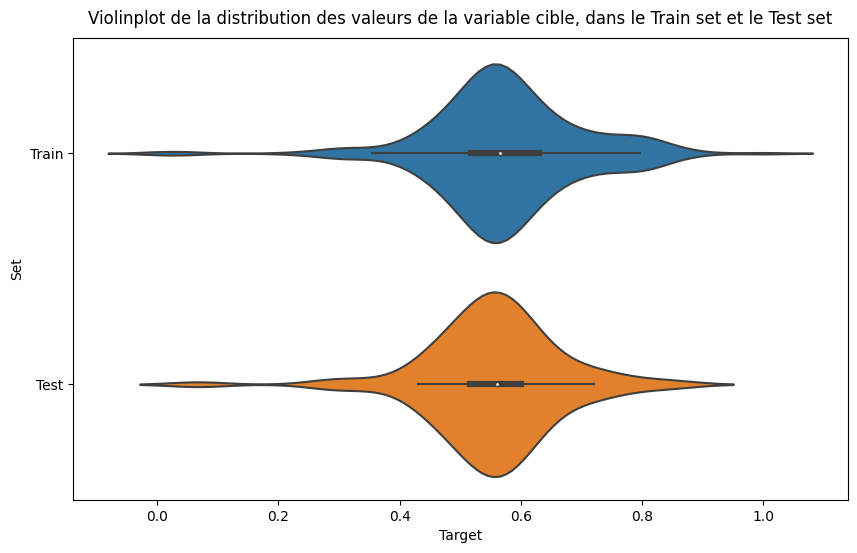

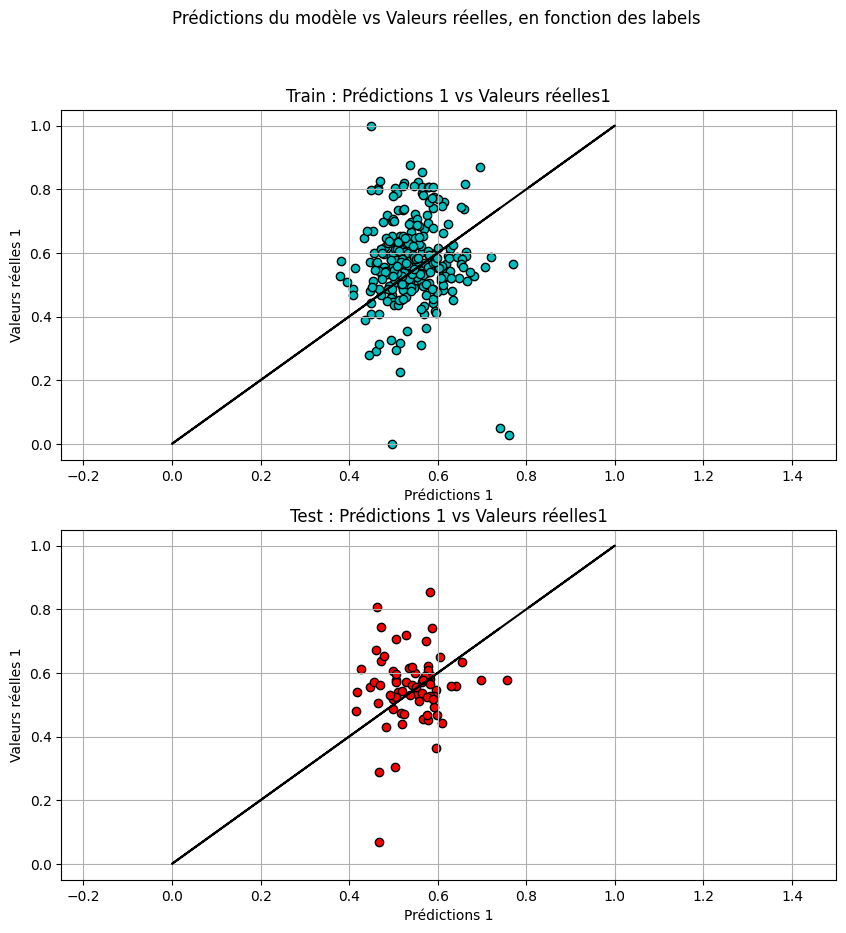

Technique + valeur du MIN(dissimilarité) : (random, 157) = 0.0014748643152415

x_train : (289, 19359)
y_train : (289, 1)
x_test : (72, 19359)
y_test : (72, 1)

MAPE = 0.24367974698543549
MSE = 0.015436266548931599
MAE = 0.09337121993303299
RMSE = 0.12424277514219284
R2 = -0.23008200526237488


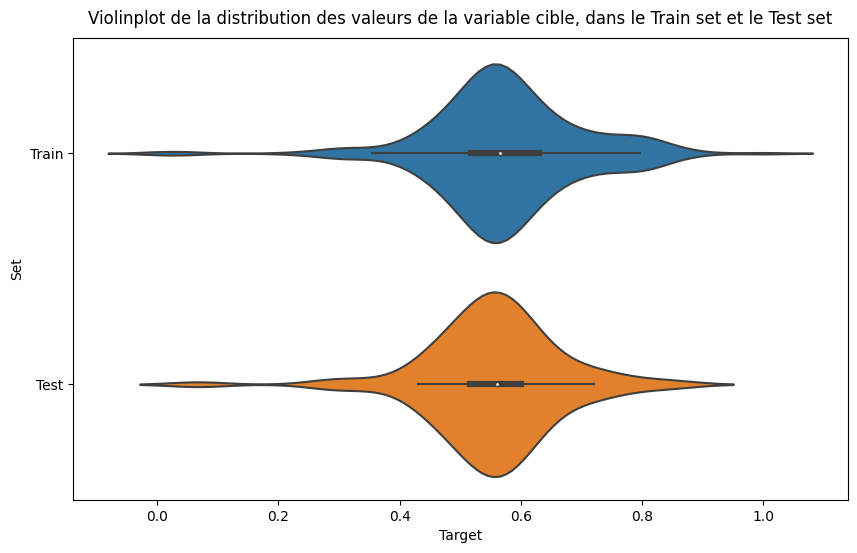

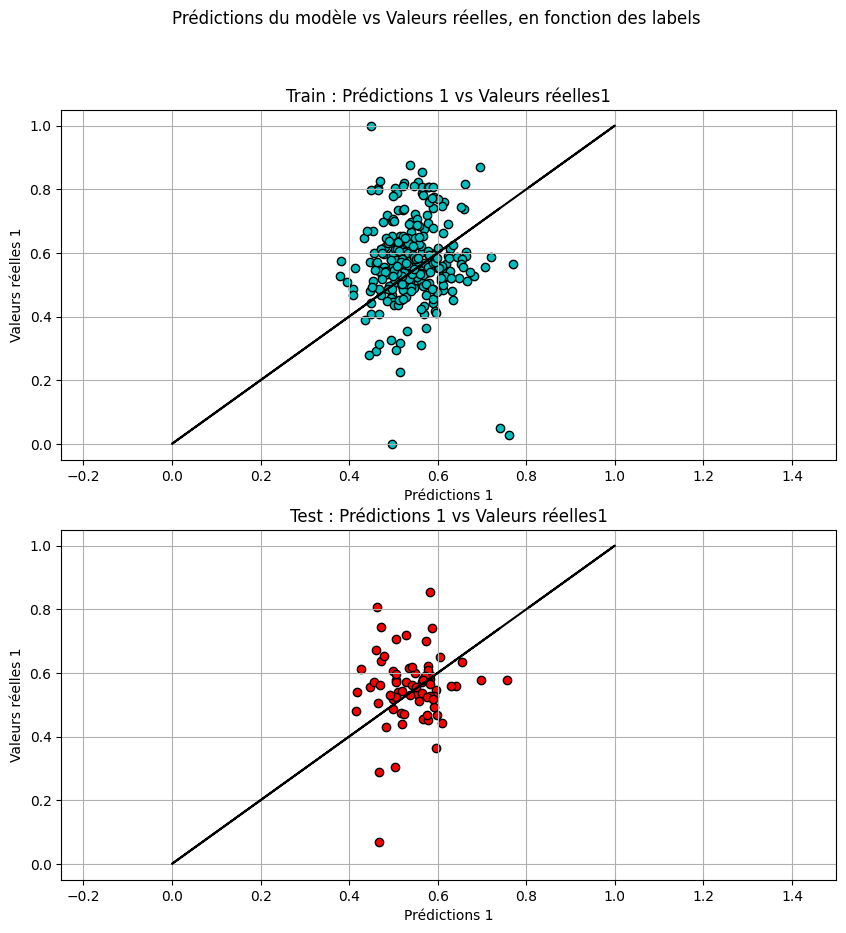

Technique + valeur du MIN(dissimilarité) : (SPlit, 257) = 0.0015082046156749

x_train : (289, 19359)
y_train : (289, 1)
x_test : (72, 19359)
y_test : (72, 1)

MAPE = 0.24367974698543549
MSE = 0.015436266548931599
MAE = 0.09337121993303299
RMSE = 0.12424277514219284
R2 = -0.23008200526237488


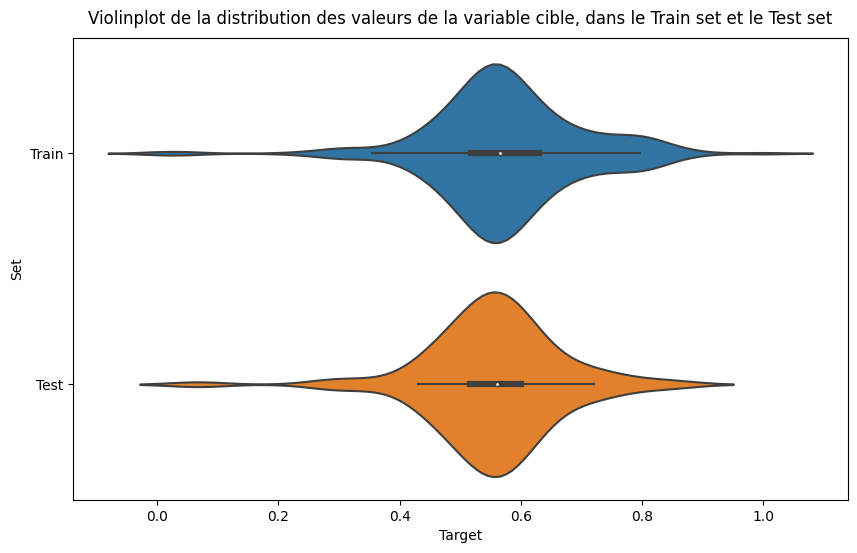

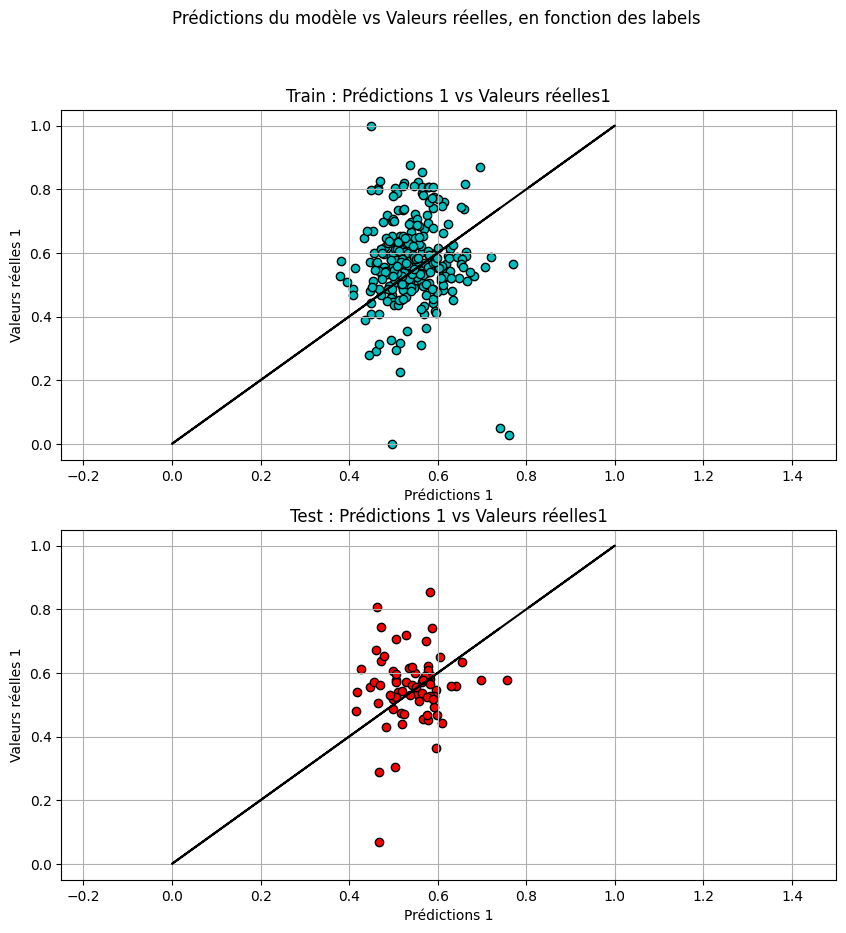

Technique + valeur du MIN(dissimilarité) : (spxy, 0) = 0.0086361607536673

x_train : (289, 19359)
y_train : (289, 1)
x_test : (72, 19359)
y_test : (72, 1)

MAPE = 0.24367974698543549
MSE = 0.015436266548931599
MAE = 0.09337121993303299
RMSE = 0.12424277514219284
R2 = -0.23008200526237488


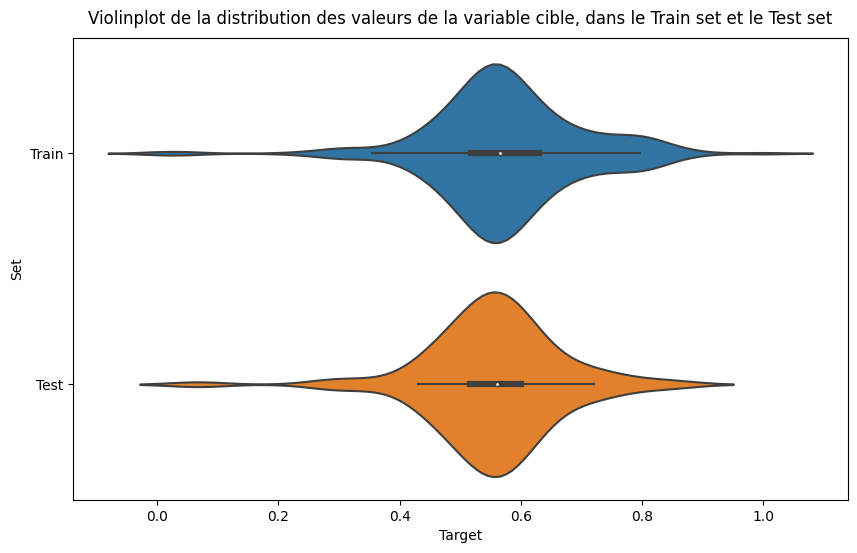

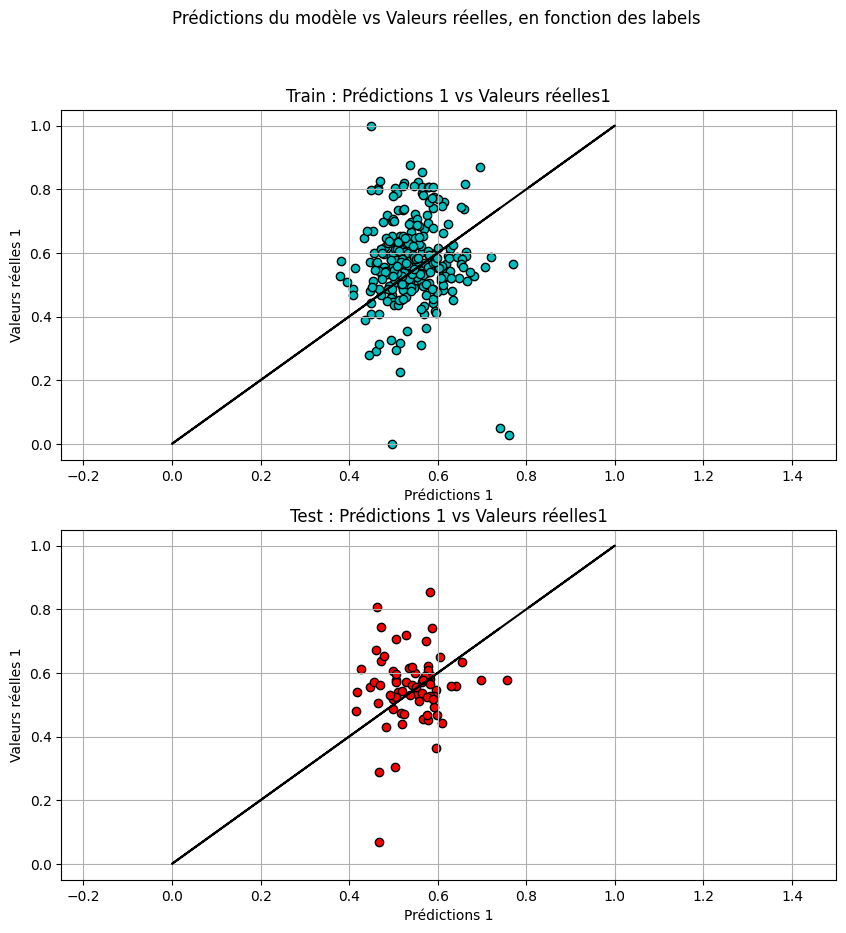

Technique + valeur du MIN(dissimilarité) : (systematic, 69) = 0.0024190044496208

x_train : (289, 19359)
y_train : (289, 1)
x_test : (72, 19359)
y_test : (72, 1)

MAPE = 0.24367974698543549
MSE = 0.015436266548931599
MAE = 0.09337121993303299
RMSE = 0.12424277514219284
R2 = -0.23008200526237488


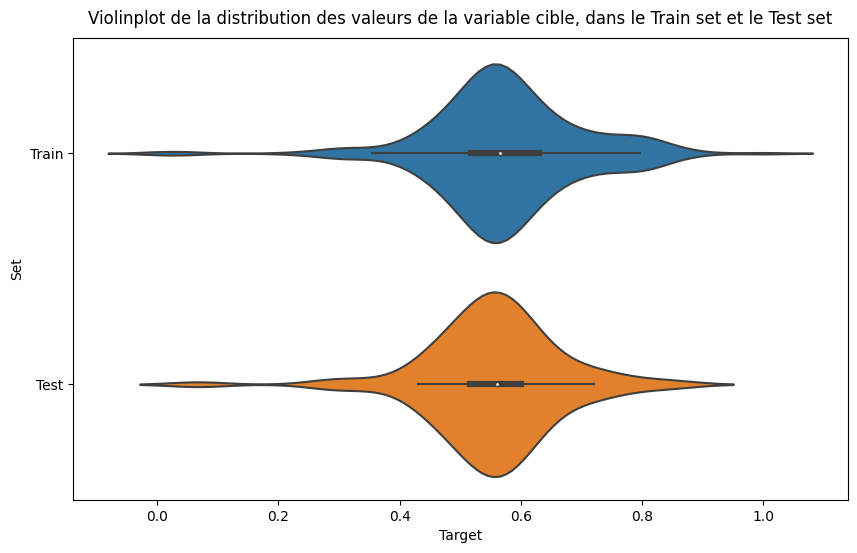

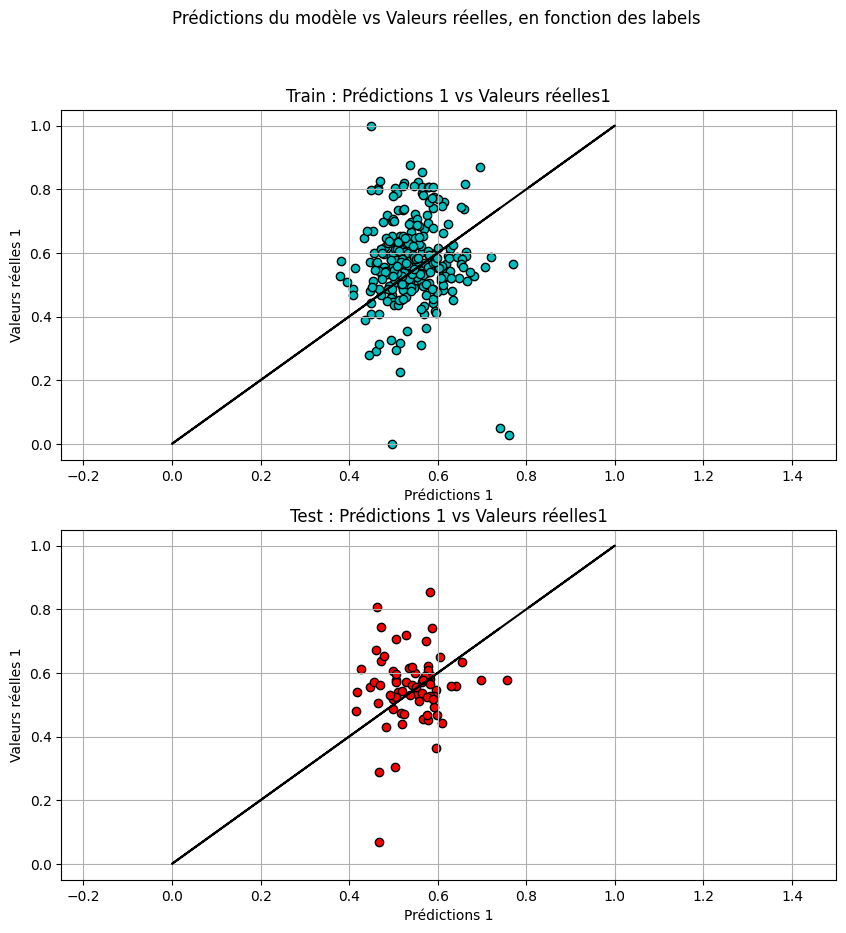

In [22]:
# Mise en place du dictionnaire de scores

dic_score = {}

# Pour chaque techniques de splitting

for tech in tab_tech:

    # Récupérer le minimum de dissimilarité

    df_tmp = df_res[df_res["Technique"] == tech]
    df_tmp = df_tmp[df_tmp["Score"] == df_tmp["Score"].min()]

    key_tech, key_r_state = df_tmp['Technique'].iloc[0], df_tmp['random_state'].iloc[0]
    value_score = df_tmp['Score'].iloc[0]

    # Split des données en fonction du combo

    x_train, x_test, y_train, y_test = st.sampling_train_test_split(features=features,
                                                                    labels=labels,
                                                                    test_size=test_size,
                                                                    tech=key_tech,
                                                                    random_state=key_r_state,
                                                                    n_cluster=n_cluster,
                                                                    pca=pca)

    # Fit de l'estimateur + Prédiction de l'estimateur

    estimator = MLPRegressor(hidden_layer_sizes=(30,),
                             activation="tanh",
                             solver="lbfgs",
                             max_iter=400,
                             random_state=0)
                             
    estimator.fit(x_train, y_train)
    pred = estimator.predict(x_test)

    # Calcule du score des métrics

    for metric in ["mape", "mse", "mae", "rmse", "r2"]:

        dic_score[(key_tech, key_r_state, metric)] = ut.metric_choice(y_test, pred, scoring=metric)

    # Visualisation de la distribution des valeurs de la variable cible + Plotting les résultats

    print("Technique + valeur du {}(dissimilarité) : ({}, {}) = {}\n".format("min".upper(), key_tech, key_r_state, value_score))
    print_shape(x_train, y_train, x_test, y_test)
    print_scores(y_test, pred)
    plot_distrib(y_train, y_test)
    pltg.plot_result(labels, x_train, x_test, y_train, y_test, estimator, largeur=10, hauteur=10)

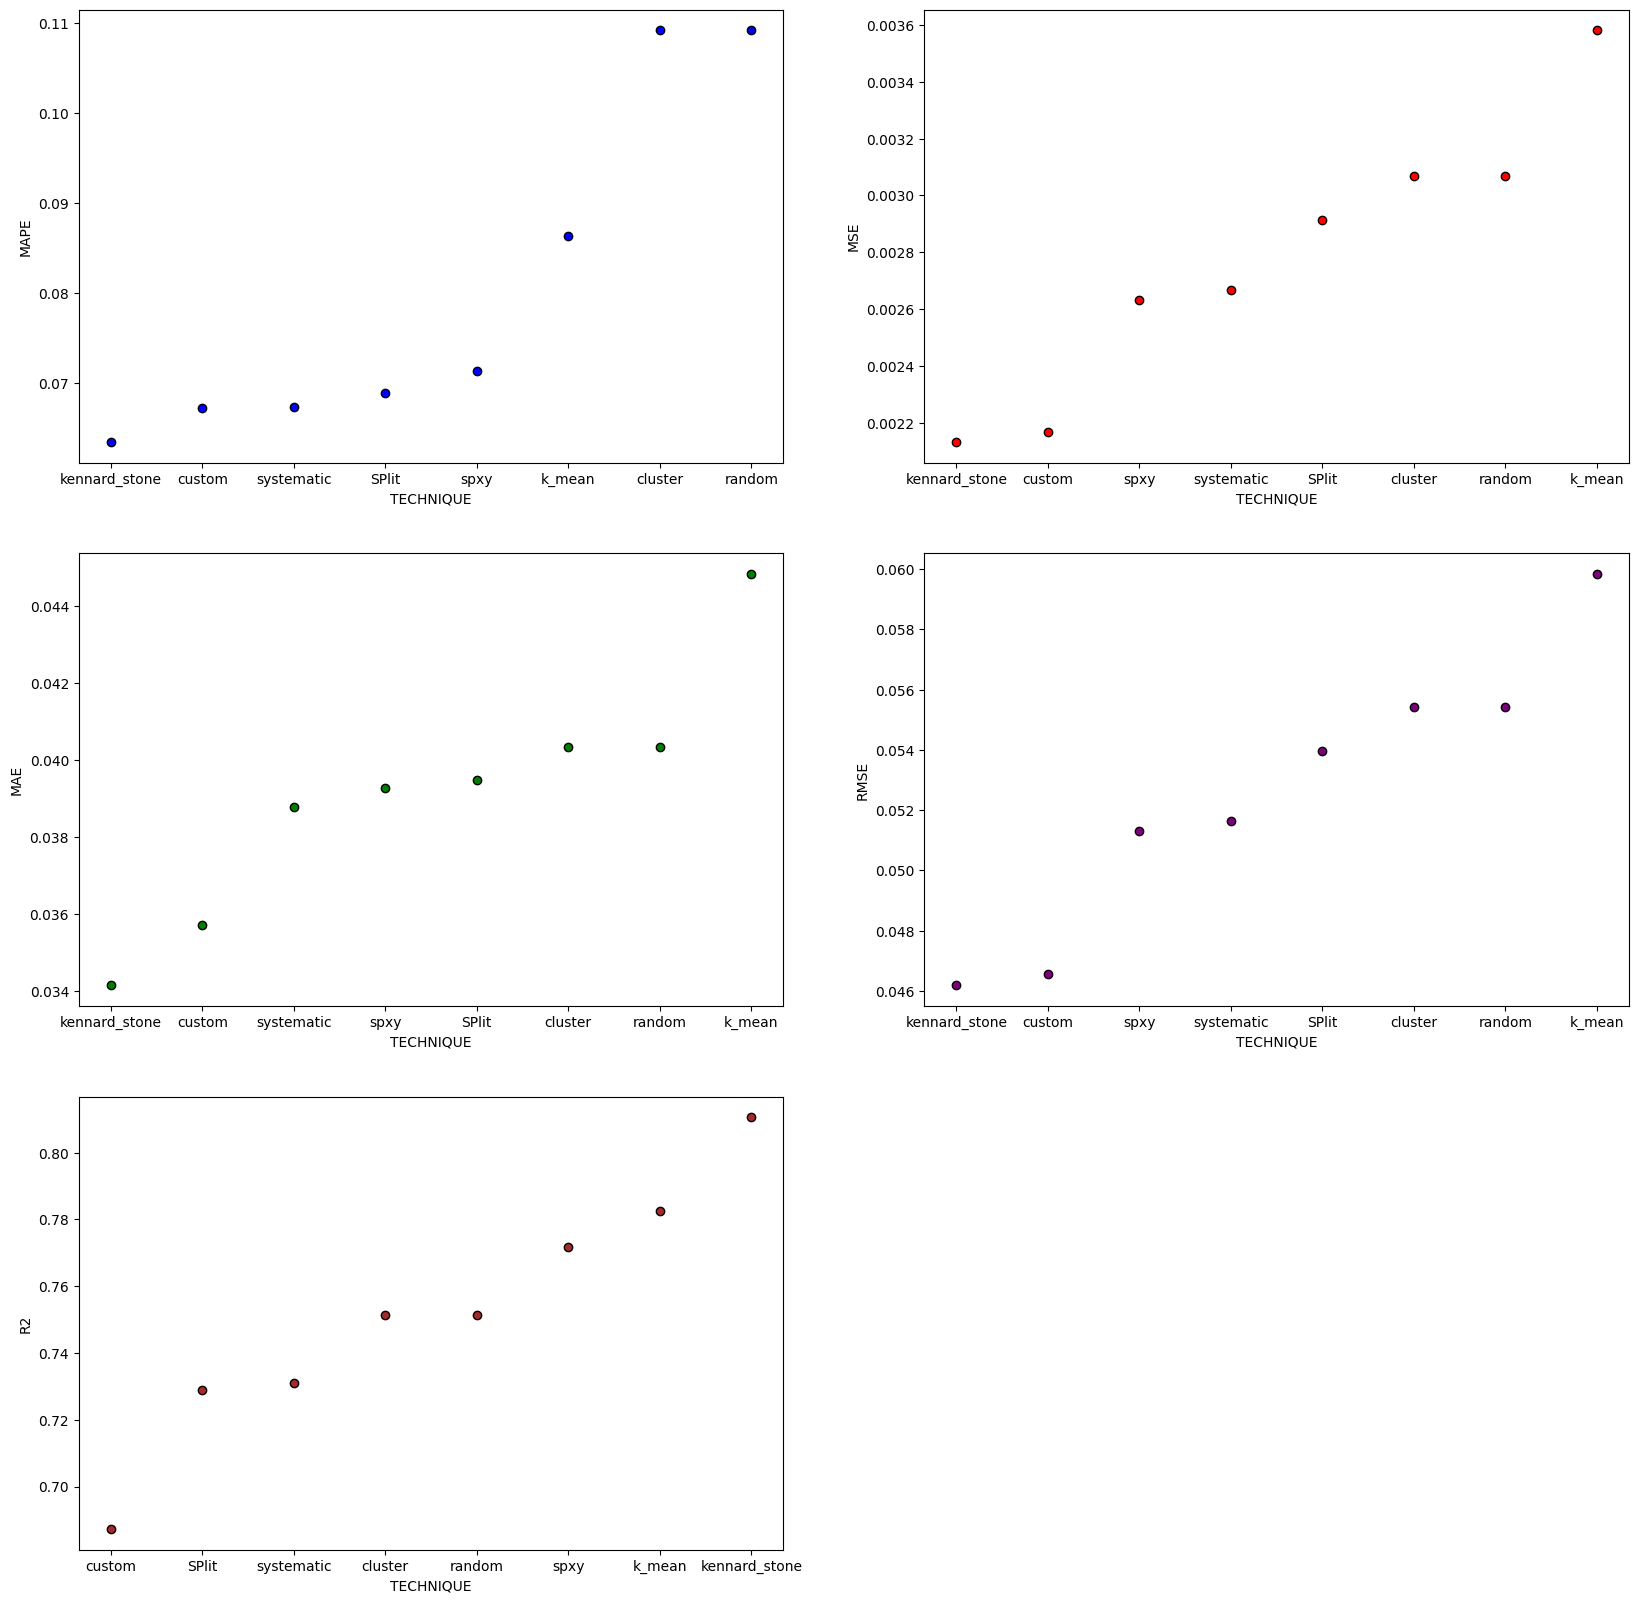

In [21]:
# Récupération des scores de métriques

df_score_metrics = get_df_metrics_values(dic_score)

# Sauvegarde des résultats

df_score_metrics.to_csv("Xcal_mlp_metric_score_res.csv", index=False)

# Plotting des résultats

plot_metrics_values(df_score_metrics)

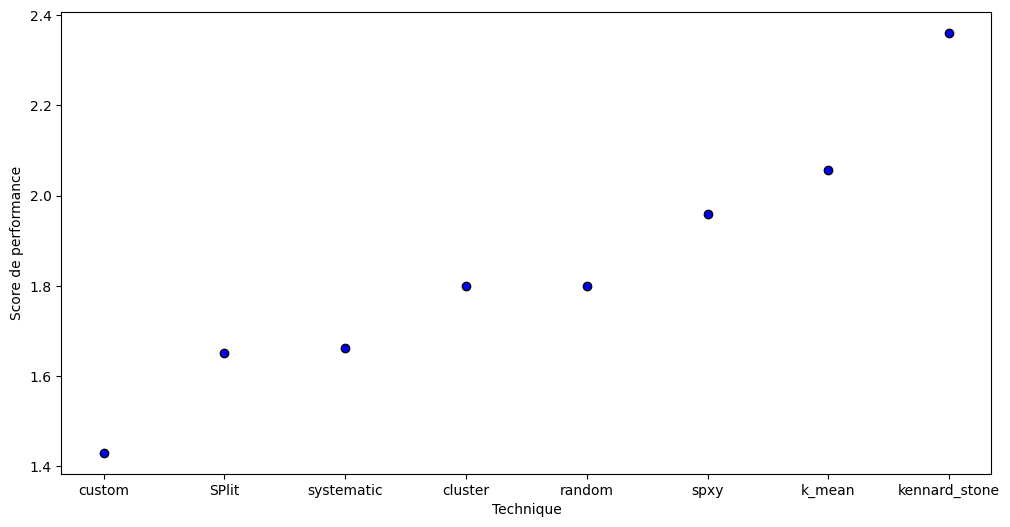

In [22]:
# Récupérer les score de performances

df_score_perf = get_df_score_perf(df_score_metrics, tab_tech)

# Sauvegarde des résultats

df_score_perf.to_csv("Xcal_mlp_perf_score_res.csv", index=False)

plot_score_perf(df_score_perf)

### Hyperparamétrisation

In [180]:
# Splitting selon le meilleur score de performance

x_train, x_test, y_train, y_test = st.sampling_train_test_split(features=features,
                                                                labels=labels,
                                                                test_size=test_size,
                                                                tech="kennard_stone",
                                                                random_state=0,
                                                                n_cluster=n_cluster,
                                                                pca=pca)

In [ ]:
# Mise en place des Kfold

kfold = KFold(n_splits=5, shuffle=False).split(x_train)

# Paramètres à tester

params = {'hidden_layer_sizes' : [(16,), (32,), (64,), (128,)],
          'max_iter' : np.arange(200, 1001, 200)}

# Création de notre métrique de score 

scorer_metric = make_scorer(compute_score_perf, greater_is_better=True)

# Recharche des meilleurs hyperparamètres

grid_cv = GridSearchCV(estimator=MLPRegressor(random_state=0, activation="tanh", solver="lbfgs"),
                       param_grid=params,
                       scoring=scorer_metric,
                       cv=kfold)

grid_cv.fit(x_train, y_train)

Best params : {'hidden_layer_sizes': (32,), 'max_iter': 400}

Best score Grid_search : 1.4375508085154078
Score performance Test set : 2.2508837456772324

MAPE = 0.06556527316570282
MSE = 0.0022372640669345856
MAE = 0.03583106771111488
RMSE = 0.04729972779750824
R2 = 0.8013164401054382


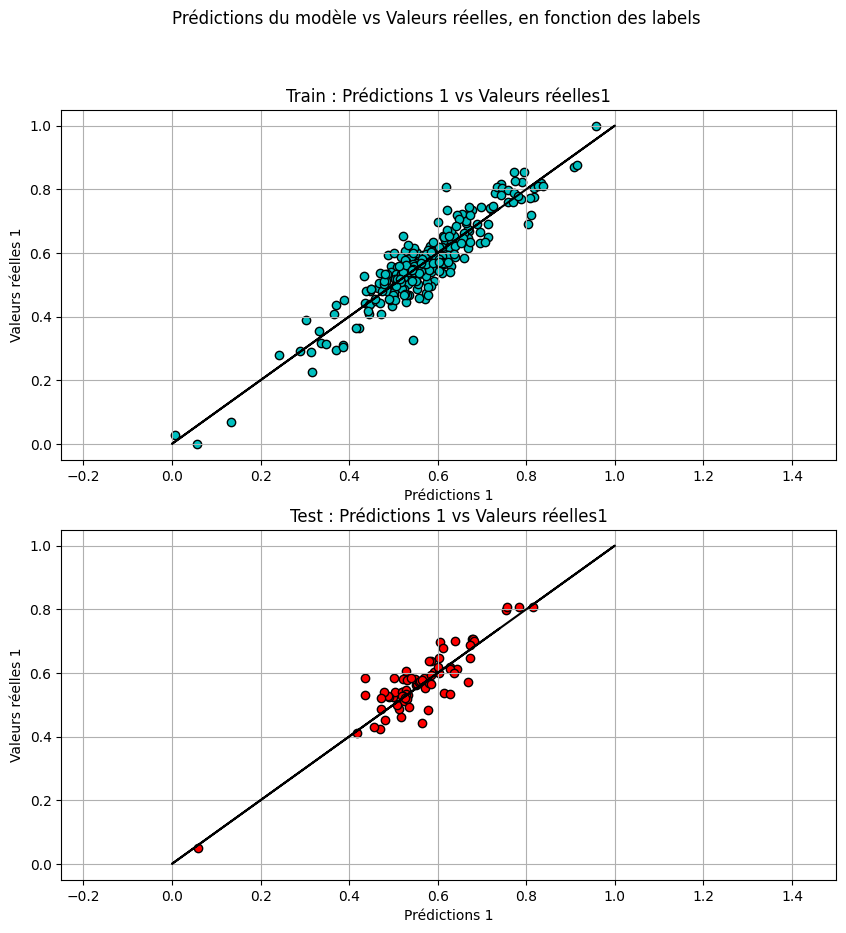

In [28]:
# Affichage des résultats

pred = grid_cv.predict(x_test)

print("Best params : {}\n".format(grid_cv.best_params_))

print("Best score Grid_search : {}".format(grid_cv.best_score_))
print("Score performance Test set : {}\n".format(compute_score_perf(y_test, pred)))

print_scores(y_test, pred)

pltg.plot_result(labels, x_train, x_test, y_train, y_test, grid_cv, largeur=10, hauteur=10)

In [ ]:
grid_cv = MLPRegressor(random_state=0, 
                       hidden_layer_sizes=30, 
                       max_iter=400
                       activation="tanh", 
                       solver="lbfgs",)

### Sauvegarde du modèle

In [ ]:
pickle.dump(grid_cv.best_estimator_, open("Xcal_mlp_grid.sav", "wb"))